# THCHS30 - 创建 Mel 频谱图

音频经过了以下变换：

1. 采样率与原始音频保持一致 `16000hz`
1. `win_length` 设置为 `100ms`，`hop_length` 设置为 `50ms`
1. Mel 频谱图 [filter-bank](https://librosa.org/doc/latest/generated/librosa.filters.mel.html) 选择 `80`
1. 将 Mel 频谱图转换成 [power spectrogram](https://librosa.org/doc/latest/generated/librosa.power_to_db.html)
1. 将取值范围调整到 `[0, 1]`

文本经过以下变换：

1. 拼音经过 [拼音字典](https://github.com/wu-jingtao/training-data/blob/master/speech_recognition/chinese/拼音字典/README.md) 转换成对应的数字索引

In [1]:
import os
import json
import glob
import datetime
import random
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm

## 挂载 Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 解压数据

数据来自：[THCHS30数据下载.ipynb](https://github.com/wu-jingtao/training-data/blob/master/speech_recognition/chinese/THCHS30/notebooks/THCHS30数据下载.ipynb)

In [3]:
!tar zxvf /content/drive/Shareddrives/TeamDrive_top_edu/原始数据/THCHS30/data_thchs30.tgz > unzip_log.txt

In [4]:
!tar zxvf /content/drive/Shareddrives/TeamDrive_top_edu/原始数据/THCHS30/test-noise.tgz > unzip_noise_log.txt

## 加载拼音字典

In [ ]:
!wget https://raw.githubusercontent.com/wu-jingtao/training-data/master/speech_recognition/chinese/拼音字典/pinyin_mapper/intonation_5.json
!wget https://raw.githubusercontent.com/wu-jingtao/training-data/master/speech_recognition/chinese/拼音字典/pinyin_mapper/intonation_4.json
!wget https://raw.githubusercontent.com/wu-jingtao/training-data/master/speech_recognition/chinese/拼音字典/pinyin_mapper/intonation_0.json
!wget https://raw.githubusercontent.com/wu-jingtao/training-data/master/speech_recognition/chinese/拼音字典/pinyin_mapper/intonation_fuzzy.json

In [6]:
with open('intonation_5.json') as f:
  pinyin_mapper_intonation_5 = json.load(f)
  
with open('intonation_4.json') as f:
  pinyin_mapper_intonation_4 = json.load(f)

with open('intonation_0.json') as f:
  pinyin_mapper_intonation_0 = json.load(f)

with open('intonation_fuzzy.json') as f:
  pinyin_mapper_intonation_fuzzy = json.load(f)

## 文件列表

In [7]:
audio_list = glob.glob('/content/data_thchs30/data/*.wav')
noise_audio_list = glob.glob('/content/test-noise/0db/**/*.wav')

打乱列表

In [8]:
random.shuffle(audio_list)
random.shuffle(audio_list)
random.shuffle(noise_audio_list)
random.shuffle(noise_audio_list)

查看效果

In [9]:
noise_audio_list[:10]

['/content/test-noise/0db/white/D8_881.wav',
 '/content/test-noise/0db/car/D11_946.wav',
 '/content/test-noise/0db/cafe/D21_882.wav',
 '/content/test-noise/0db/white/D13_899.wav',
 '/content/test-noise/0db/cafe/D11_973.wav',
 '/content/test-noise/0db/cafe/D4_828.wav',
 '/content/test-noise/0db/cafe/D7_922.wav',
 '/content/test-noise/0db/cafe/D31_925.wav',
 '/content/test-noise/0db/car/D7_798.wav',
 '/content/test-noise/0db/car/D11_876.wav']

## 读取音频对应的文本

In [10]:
audio_words = dict()
audio_pinyins = dict()

for path in audio_list:
  name = os.path.splitext(os.path.split(path)[1])[0]
  with open(path + '.trn') as f:
    words = next(f).strip()
    words = list(filter(lambda x: x != ' ', words))
    pinyins = next(f).strip().split(' ')
    audio_words[name] = words
    audio_pinyins[name] = pinyins

## 构建 [Mel](https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html) 频谱图

In [11]:
def get_melspectrogram(file_list):
  def generator():
    for path in file_list:
      audio, sr = librosa.load(path, sr=None)
      S = librosa.feature.melspectrogram(audio, sr, n_fft=sr // 10, hop_length=sr // 20, n_mels=80)
      S_dB = librosa.power_to_db(S, ref=np.max) # 这里顺带做了音量统一
      S_dB = (S_dB + 80) / 80
      yield S_dB.T
  return generator

In [35]:
mel = tf.data.Dataset.from_generator(get_melspectrogram(audio_list), output_signature=tf.TensorSpec(shape=(None, 80), dtype=tf.float32))
noise_mel = tf.data.Dataset.from_generator(get_melspectrogram(noise_audio_list), output_signature=tf.TensorSpec(shape=(None, 80), dtype=tf.float32))

查看频谱图

mel频谱形状 (162, 80)


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

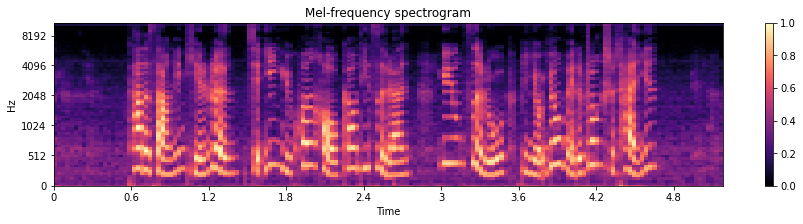

In [55]:
sample_data = next(mel.as_numpy_iterator())
print(f'mel频谱形状 {sample_data.shape}')

fig, ax = plt.subplots(figsize=(15, 3))
img = librosa.display.specshow(sample_data.T, x_axis='time', y_axis='mel', sr=16000, ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Mel-frequency spectrogram')

查看音频

In [ ]:
# 由于是使用 Griffin-Lim 算法复原的所以效果不太好，但这并不会影响到语音识别
sample_data = sample_data.T * 80 - 80
sample_data = librosa.db_to_power(sample_data)
sample_data = librosa.feature.inverse.mel_to_audio(sample_data, sr=16000, n_fft=16000 // 10, hop_length=16000 // 20)
ipd.Audio(sample_data, rate=16000)

## 构建文本

In [15]:
def get_words(file_list):
  def generator():
    for path in file_list:
      name = os.path.splitext(os.path.split(path)[1])[0]
      yield audio_words[name]
  return generator

In [36]:
words = tf.data.Dataset.from_generator(get_words(audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.string))
noise_words = tf.data.Dataset.from_generator(get_words(noise_audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.string))

查看效果

In [17]:
' '.join(map(lambda x: str(x, 'utf-8'), next(words.as_numpy_iterator())))

'她 的 嗓 音 甜 润 且 音 域 宽 厚 高 低 自 然 运 用 自 如 并 有 优 美 的 装 饰 颤 音'

## 构建拼音

In [18]:
def get_pinyins(file_list):
  def generator():
    for path in file_list:
      name = os.path.splitext(os.path.split(path)[1])[0]
      yield audio_pinyins[name]
  return generator

In [37]:
pinyins = tf.data.Dataset.from_generator(get_pinyins(audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.string))
noise_pinyins = tf.data.Dataset.from_generator(get_pinyins(noise_audio_list), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.string))

查看效果

In [20]:
' '.join(map(lambda x: str(x, 'utf-8'), next(pinyins.as_numpy_iterator())))

'ta1 de5 sang3 yin1 tian2 run4 qie3 yin1 yu4 kuan1 hou4 gao1 di1 zi4 ran2 yun4 yong4 zi4 ru2 bing4 you3 you1 mei3 de5 zhuang1 shi4 chan4 yin1'

## 构建拼音索引

In [26]:
def get_pinyin_index(dataset, pinyin_mapper):
  def generator():
    for sentence in dataset.as_numpy_iterator():
      yield np.array(list(map(lambda x: pinyin_mapper[str(x, 'utf-8')], sentence)), dtype=np.int32)
  return generator

In [38]:
# 五种声调
pinyin_index_5 = tf.data.Dataset.from_generator(get_pinyin_index(pinyins, pinyin_mapper_intonation_5), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))
noise_pinyin_index_5 = tf.data.Dataset.from_generator(get_pinyin_index(noise_pinyins, pinyin_mapper_intonation_5), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))

# 四种声调
pinyin_index_4 = tf.data.Dataset.from_generator(get_pinyin_index(pinyins, pinyin_mapper_intonation_4), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))
noise_pinyin_index_4 = tf.data.Dataset.from_generator(get_pinyin_index(noise_pinyins, pinyin_mapper_intonation_4), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))

# 无声调
pinyin_index_0 = tf.data.Dataset.from_generator(get_pinyin_index(pinyins, pinyin_mapper_intonation_0), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))
noise_pinyin_index_0 = tf.data.Dataset.from_generator(get_pinyin_index(noise_pinyins, pinyin_mapper_intonation_0), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))

# 无声调 + 模糊音
pinyin_index_fuzzy = tf.data.Dataset.from_generator(get_pinyin_index(pinyins, pinyin_mapper_intonation_fuzzy), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))
noise_pinyin_index_fuzzy = tf.data.Dataset.from_generator(get_pinyin_index(noise_pinyins, pinyin_mapper_intonation_fuzzy), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))

查看效果

In [24]:
sample_data = next(pinyin_index_5.as_numpy_iterator())
sample_data = list(map(lambda x: str(x), sample_data))
print(' '.join(sample_data))
print(' '.join(map(lambda x: pinyin_mapper_intonation_5[x], sample_data)))

1585 309 1427 1825 1626 1403 1297 1825 1853 790 613 485 325 2018 1341 1868 1843 2018 1386 93 1847 1845 982 309 1995 1498 158 1825
ta1 de5 sang3 yin1 tian2 run4 qie3 yin1 yu4 kuan1 hou4 gao1 di1 zi4 ran2 yun4 yong4 zi4 ru2 bing4 you3 you1 mei3 de5 zhuang1 shi4 chan4 yin1


## 创建缓存数据

无噪音数据

In [33]:
!mkdir THCHS30_mel

In [39]:
mel_cache = mel.cache('THCHS30_mel/audios')
words_cache = words.cache('THCHS30_mel/words')
pinyins_cache = pinyins.cache('THCHS30_mel/pinyins')
pinyin_index_5_cache = pinyin_index_5.cache('THCHS30_mel/pinyin_index_5')
pinyin_index_4_cache = pinyin_index_4.cache('THCHS30_mel/pinyin_index_4')
pinyin_index_0_cache = pinyin_index_0.cache('THCHS30_mel/pinyin_index_0')
pinyin_index_fuzzy_cache = pinyin_index_fuzzy.cache('THCHS30_mel/pinyin_index_fuzzy')

In [40]:
with tqdm(total=len(audio_list), desc='mel_cache') as pbar:
  for i in mel_cache: pbar.update()

with tqdm(total=len(audio_list), desc='words_cache') as pbar:
  for i in words_cache: pbar.update()

with tqdm(total=len(audio_list), desc='pinyins_cache') as pbar:
  for i in pinyins_cache: pbar.update()

with tqdm(total=len(audio_list), desc='pinyin_index_5_cache') as pbar:
  for i in pinyin_index_5_cache: pbar.update()

with tqdm(total=len(audio_list), desc='pinyin_index_4_cache') as pbar:
  for i in pinyin_index_4_cache: pbar.update()

with tqdm(total=len(audio_list), desc='pinyin_index_0_cache') as pbar:
  for i in pinyin_index_0_cache: pbar.update()

with tqdm(total=len(audio_list), desc='pinyin_index_fuzzy_cache') as pbar:
  for i in pinyin_index_fuzzy_cache: pbar.update()

pinyin_index_fuzzy_cache: 100%|██████████| 13388/13388 [00:12<00:00, 1043.77it/s]


有噪音数据

In [41]:
!mkdir THCHS30_mel_noise

In [44]:
noise_mel_cache = noise_mel.cache('THCHS30_mel_noise/audios')
noise_words_cache = noise_words.cache('THCHS30_mel_noise/words')
noise_pinyins_cache = noise_pinyins.cache('THCHS30_mel_noise/pinyins')
noise_pinyin_index_5_cache = noise_pinyin_index_5.cache('THCHS30_mel_noise/pinyin_index_5')
noise_pinyin_index_4_cache = noise_pinyin_index_4.cache('THCHS30_mel_noise/pinyin_index_4')
noise_pinyin_index_0_cache = noise_pinyin_index_0.cache('THCHS30_mel_noise/pinyin_index_0')
noise_pinyin_index_fuzzy_cache = noise_pinyin_index_fuzzy.cache('THCHS30_mel_noise/pinyin_index_fuzzy')

In [45]:
with tqdm(total=len(noise_audio_list), desc='noise_mel_cache') as pbar:
  for i in noise_mel_cache: pbar.update()

with tqdm(total=len(noise_audio_list), desc='noise_words_cache') as pbar:
  for i in noise_words_cache: pbar.update()

with tqdm(total=len(noise_audio_list), desc='noise_pinyins_cache') as pbar:
  for i in noise_pinyins_cache: pbar.update()

with tqdm(total=len(noise_audio_list), desc='noise_pinyin_index_5_cache') as pbar:
  for i in noise_pinyin_index_5_cache: pbar.update()

with tqdm(total=len(noise_audio_list), desc='noise_pinyin_index_4_cache') as pbar:
  for i in noise_pinyin_index_4_cache: pbar.update()

with tqdm(total=len(noise_audio_list), desc='noise_pinyin_index_0_cache') as pbar:
  for i in noise_pinyin_index_0_cache: pbar.update()

with tqdm(total=len(noise_audio_list), desc='noise_pinyin_index_fuzzy_cache') as pbar:
  for i in noise_pinyin_index_fuzzy_cache: pbar.update()

noise_pinyin_index_fuzzy_cache: 100%|██████████| 7485/7485 [00:06<00:00, 1110.54it/s]


## 创建说明文件

In [47]:
readme = '''数据来源：http://www.openslr.org/18/
项目地址：https://github.com/wu-jingtao/training-data/blob/master/speech_recognition/chinese/README.md
创建时间：{}

数据类型：
audios：音频对应的 mel 频谱图
  {}

words：音频对应的文字
  {}

pinyins：音频对应的拼音
  {}

pinyin_index_5：音频对应的五声声调拼音索引
  {}

pinyin_index_4：音频对应的四声声调拼音索引
  {}

pinyin_index_0：音频对应的无声调拼音索引
  {}

pinyin_index_fuzzy：音频对应的无声调加模糊音拼音索引
  {}

示例代码：
>>> data = tf.data.Dataset.from_generator(lambda: None, output_signature=tf.TensorSpec(shape=(None, 80), dtype=tf.float32))
>>> data = data.cache('文件夹路径/audio')
'''

readme = readme.format(
      datetime.datetime.today(),
      mel_cache.element_spec,
      words_cache.element_spec,
      pinyins_cache.element_spec,
      pinyin_index_5_cache.element_spec,
      pinyin_index_4_cache.element_spec,
      pinyin_index_0_cache.element_spec,
      pinyin_index_fuzzy_cache.element_spec
    )

with open('THCHS30_mel/README.txt', 'w') as f:
  f.write(readme)

with open('THCHS30_mel_noise/README.txt', 'w') as f:
  f.write(readme)

## 压缩文件

In [48]:
!7z a THCHS30_mel.7z THCHS30_mel > zip_log.txt

In [49]:
!7z a THCHS30_mel_noise.7z THCHS30_mel_noise > zip_noise_log.txt

## 保存到 Google Drive

In [50]:
!cp THCHS30_mel.7z /content/drive/Shareddrives/TeamDrive_top_edu/生成数据/THCHS30_mel.7z

In [51]:
!cp THCHS30_mel_noise.7z /content/drive/Shareddrives/TeamDrive_top_edu/生成数据/THCHS30_mel_noise.7z

In [52]:
!cp -r THCHS30_mel /content/drive/Shareddrives/TeamDrive_top_edu/生成数据/

In [53]:
!cp -r THCHS30_mel_noise /content/drive/Shareddrives/TeamDrive_top_edu/生成数据/